# Neural network for CAN signal prediction

Steering Angle 값을 예측하는 단순 Feedforward network


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

## 데이터 읽어 오기

뉴럴 네트워크에서는 데이터를 잘 준비하는 것이 중요함. 서로 Range가 다른 값들을 효과적으로 학습 시키려면 적절한 scaling과 값 분류가 필요함.

In [2]:
data_path = 'SAS.csv'

can = pd.read_csv(data_path)
can.shape

(3615, 17)

In [3]:
can.head()


,SAS_Angle[Deg],SAS_Speed,CR_Yrs_Yr,CR_Yrs_LatAc[g],ACCEL_REF_ACC[m/s^2],DriverBraking,CR_Mdps_DrvTq,CR_Brk_StkDep_Pc[%],CR_Yrs_LongAc[g],CR_Mdps_StrColTq[Nm],CR_Mdps_StrTq[Nm],CR_Mdps_OutTq,CF_Gway_TSigLHSw,CF_Gway_TSigRHSw,CR_Vcu_AccPedDep_Pc[%],CR_Mcu_VehSpd_Kph[kph],Time[s]
0,8.9,0,0.220,0.041936,0.0,1,-0.06,38,0.035180,-0.062500,-0.06,0.0,0,0,0.0,0,241
1,8.9,0,0.195,0.039897,0.0,1,-0.06,38,0.032504,-0.062500,-0.06,0.0,0,0,0.0,0,242
2,8.9,0,0.260,0.040151,0.0,1,-0.06,38,0.028935,-0.062500,-0.06,0.0,0,0,0.0,0,243
3,8.9,0,0.255,0.043083,0.0,1,-0.06,39,0.031739,-0.054688,-0.06,0.0,0,0,0.0,0,244
4,8.9,0,0.210,0.044995,0.0,1,-0.06,39,0.034033,-0.062500,-0.06,0.0,0,0,0.0,0,245


## 데이터 확인

1초 단위로 샘플링한 차량의 CAN 데이터로 스티어링 각도, 스티어링 토크, Yaw, 가속도, Braking, Accel pedal, 차속, Turn signal 등의 정보를 담고 있음.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

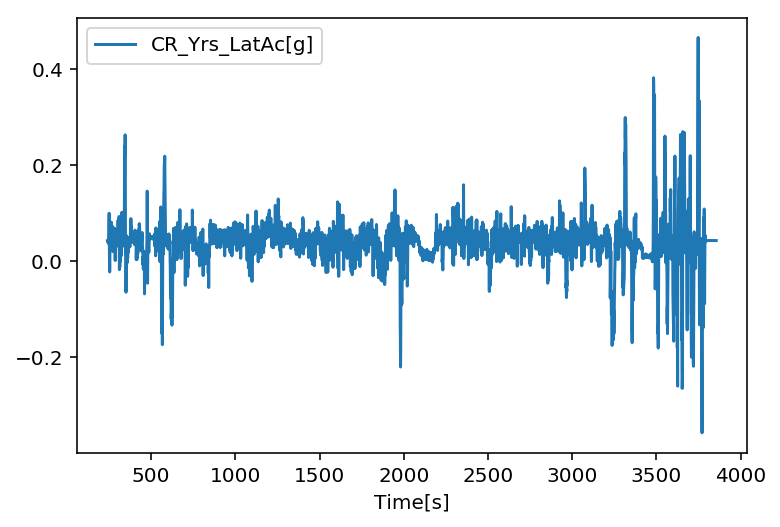

In [4]:
can[:].plot(x='Time[s]', y='CR_Yrs_LatAc[g]')
#can[:].plot(x='Time[s]', y='SAS_Angle[Deg]')

#can[:24*10].plot(x='CR_Vcu_AccPedDep_Pc[%]', y='CR_Vcu_WhlDemTq_Nm[Nm]')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['DriverBraking', 'CF_Gway_TSigLHSw', 'CF_Gway_TSigRHSw']
for each in dummy_fields:
    dummies = pd.get_dummies(can[each], prefix=each, drop_first=False)
    can = pd.concat([can, dummies], axis=1)

fields_to_drop = ['CR_Yrs_Yr', 'ACCEL_REF_ACC[m/s^2]', 'CR_Mdps_StrTq[Nm]', 'CR_Mdps_OutTq', 
                  'DriverBraking', 'CF_Gway_TSigLHSw', 'CF_Gway_TSigRHSw', 'Time[s]']
data = can.drop(fields_to_drop, axis=1)
data.head()
#type(data)
data.shape

(3615, 15)

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['SAS_Angle[Deg]', 'SAS_Speed', 'CR_Yrs_LatAc[g]', 'CR_Mdps_DrvTq', 'CR_Brk_StkDep_Pc[%]', 
                 'CR_Yrs_LongAc[g]', 'CR_Mdps_StrColTq[Nm]','CR_Vcu_AccPedDep_Pc[%]', 'CR_Mcu_VehSpd_Kph[kph]' ]
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std   # loc : label을 가지고 row나 column을 access

type(data)
data.head()
print("data_size :",data.shape)

data_size : (3615, 15)


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-1084:]    # 뒤에서 1084 번째 부터 데이터 끝까지 30%
print(test_data.shape)
# Now remove the test data from the data set 
data = data[:-1084]         # 처음부터 뒤에서 1084 제외한 데이터까지 

# Separate the data into features and targets
target_fields = ['SAS_Angle[Deg]']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
print("test_data", test_data.shape)
print("data", data.shape)

(1084, 15)
test_data (1084, 15)
data (2531, 15)


We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-759], targets[:-759]
val_features, val_targets = features[-759:], targets[-759:]
train_features.shape
val_features.shape
features.shape

(2531, 14)

## Time to build the network

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

#from my_answers import NeuralNetwork

In [10]:
#############
# Create Neural Network
#############


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### sigmoid function ####
        self.activation_function = lambda x : 1. / (1. + np.exp(-x))  
        
        ### If the lambda code above is not something you're familiar with,
        #def sigmoid(x):
        #    return 1. / (1. + np.exp(-x1))  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # Implement the forward pass function below
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
            
            self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        #### Implement the forward pass here ####
       
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer, The activation function is 𝑓(𝑥)=𝑥
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        # Backpropagated error terms
        # output_error_term = error * output function gradient
        output_error_term = error # since the activation function for output is 𝑓(𝑥)=𝑥
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:,None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:,None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass ####
        # Hidden layer 
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs



In [55]:

#########################################################
# Set hyperparameters
##########################################################
iterations = 2000
learning_rate = 0.01
hidden_nodes = 56
output_nodes = 1


In [56]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [57]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    #def test_data_path(self):
        # Test that file path to dataset has been unaltered
        #self.assertTrue(data_path.lower() == 'bike-sharing-dataset/SAS.csv')
        
    #def test_data_loaded(self):
        # Test that data frame loaded
        #self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [58]:
#import sys


####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['SAS_Angle[Deg]']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['SAS_Angle[Deg]'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['SAS_Angle[Deg]'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 1.1% ... Training loss: 0.718 ... Validation loss: 0.016

/home/kzi/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 100.0% ... Training loss: 0.029 ... Validation loss: 0.088

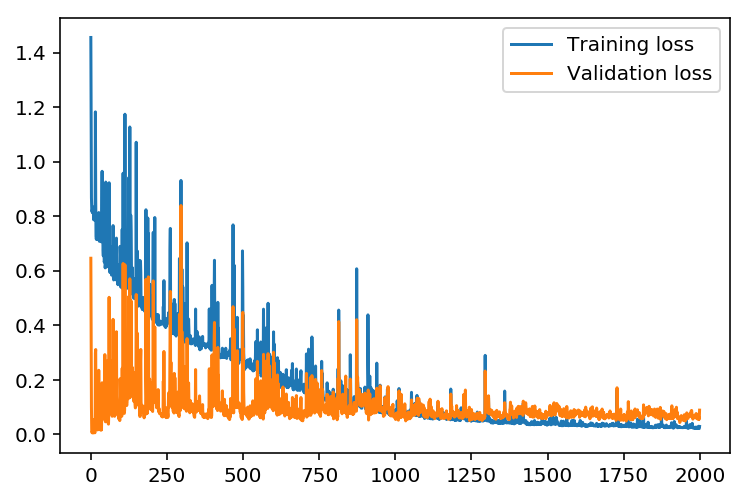

In [59]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

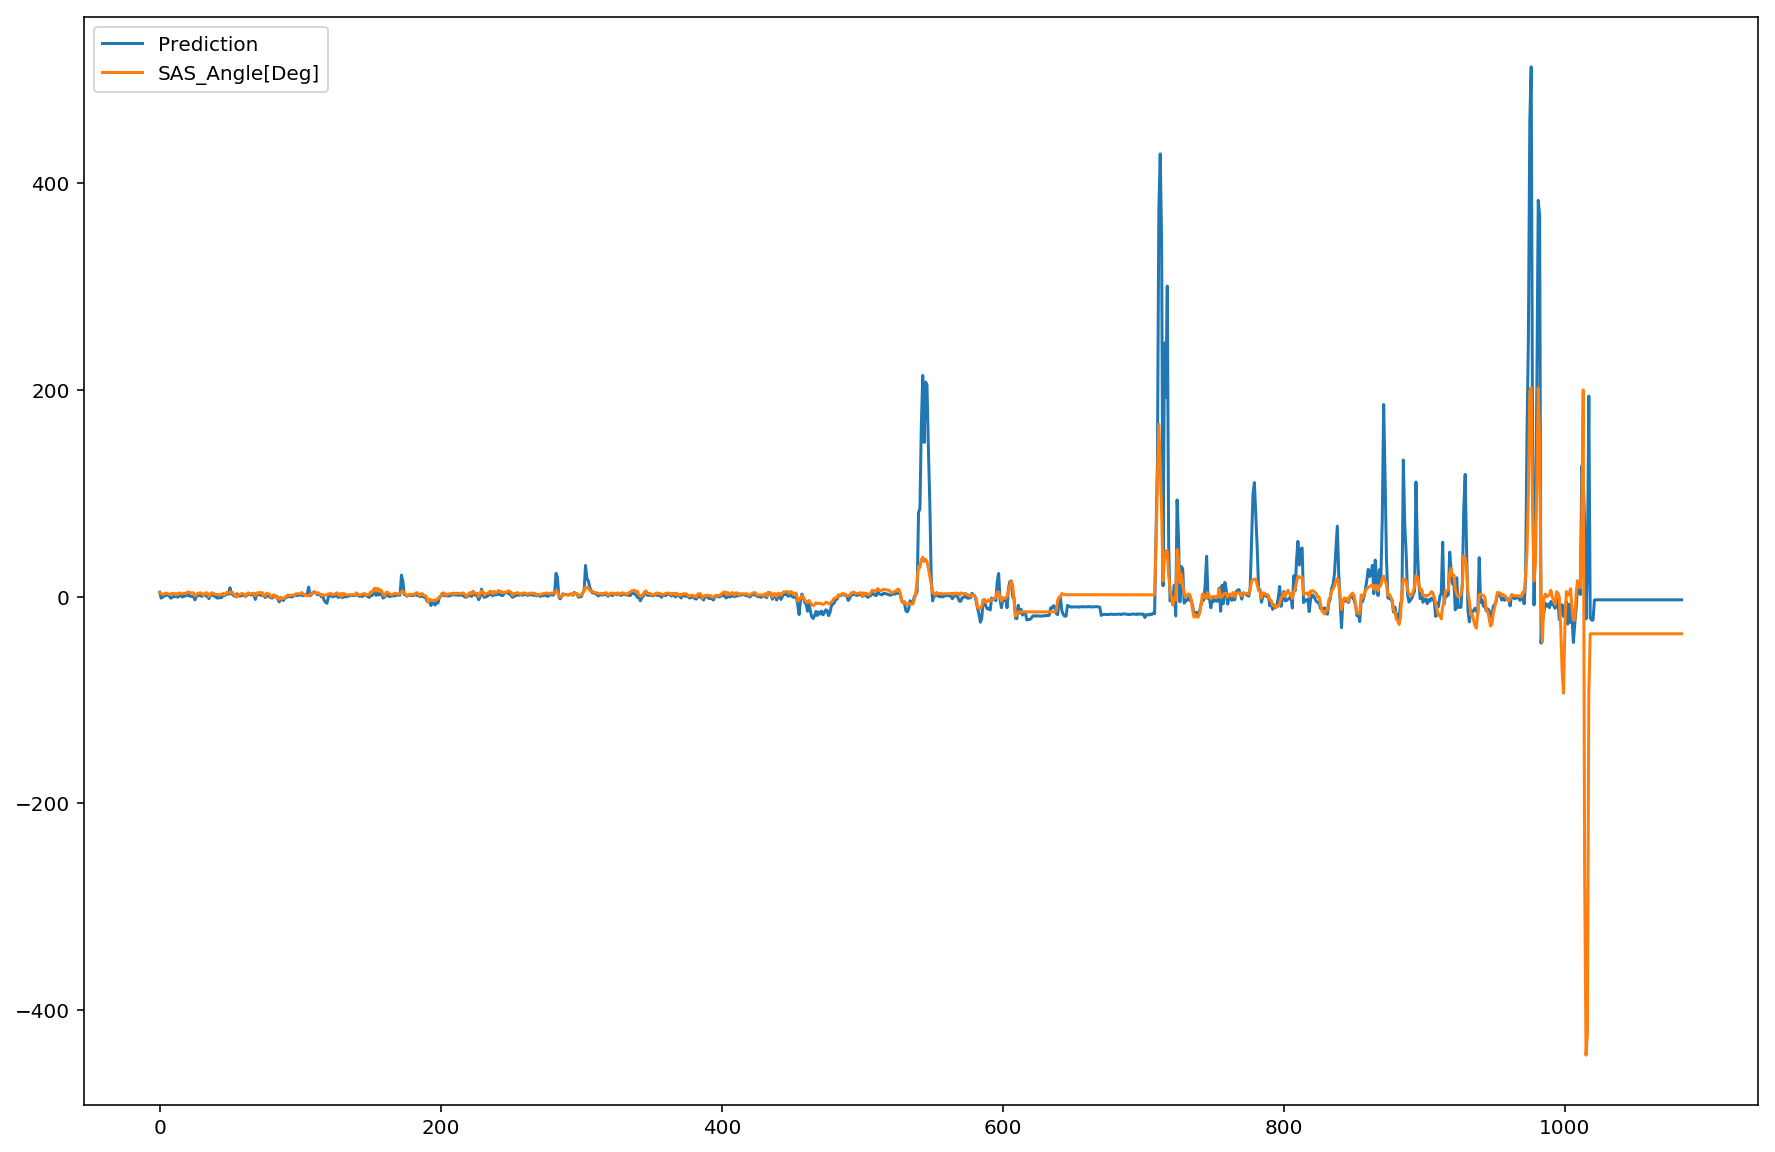

In [61]:
fig, ax = plt.subplots(figsize=(15,10))

mean, std = scaled_features['SAS_Angle[Deg]']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['SAS_Angle[Deg]']*std + mean).values, label='SAS_Angle[Deg]')
#ax.set_xlim(right=len(predictions))
ax.legend()

#ax.set_xticks(np.arange(test_data.shape[0]))
#ax.set_xticks(test_data.shape[0])
#dates = pd.to_datetime(rides.ix[test_data.index]['Time[s]'])
#dates = dates.apply(lambda d: d.strftime('%b %d'))
#ax.set_xticks(np.arange(len(dates))[12::24])
#_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
Prediction performance seems to be determined by the number of hidden units and iterations. Most of fail areas are focused on spike one. More closer to the inital data, more far with later data. 

In [ ]:
import torch

In [ ]:
cuda = torch.cuda.is_available()

In [ ]:
cuda

In [ ]:
from numba import cuda

In [ ]:
print(cuda.gpus)